Loading some librairies.
Setting variables.
Defining some useful functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
numerical_columns = ['consommation_brute_gaz_grtgaz', 'consommation_brute_gaz_terega', 'consommation_brute_gaz_totale', 
                       'consommation_brute_electricite_rte', 'consommation_brute_totale']
cardinal_columns = ['mois', 'jour', 'heure']
ordinal_columns = ['statut_grtgaz', 'statut_terega', 'statut_rte']

In [3]:
def create_time_series(X, length):
    X_ts_shape = (X.shape[0]-length, length) + tuple(dim for dim in X.shape[1:])
    X_ts = np.zeros(X_ts_shape)
    y = np.zeros_like(X)[length:]

    for i in range(y.shape[0]):
        for j in range(length):
            X_ts[i][j] = X[i + j]
        y[i] = X[i + length]

    return X_ts, y


def create_dataset_numpy_array(data, ts_lenght):
    data = data.sort_values(by='date_heure', ascending=True)
    X = data.drop(['date_heure', 'date'], axis=1)
    X = normalize_data(X)

    return create_time_series(X, length=ts_lenght)    

In [4]:
def basic_plot(data_x, data_y, title, labels):
    plt.figure(figsize=(12, 6))
    plt.plot(data_x, data_y, label=labels['label'])
    plt.title(title)
    plt.xlabel(labels['xlabel'])
    plt.ylabel(labels['ylabel'])
    plt.legend()
    plt.show()

Data preparation and a first shot to visualise the data.

In [5]:
file_path = 'consommation-quotidienne-brute.csv'  
data = pd.read_csv(file_path, delimiter=';')
data.head(10)

,date_heure,date,heure,consommation_brute_gaz_grtgaz,statut_grtgaz,consommation_brute_gaz_terega,statut_terega,consommation_brute_gaz_totale,consommation_brute_electricite_rte,statut_rte,consommation_brute_totale
0,2023-08-31T23:30:00+02:00,31/08/2023,23:30,NaN,NaN,NaN,NaN,NaN,42710,Consolidé,NaN
1,2023-08-31T23:00:00+02:00,31/08/2023,23:00,23599.0,Définitif,1114.0,Définitif,24713.0,43562,Consolidé,68275.0
2,2023-08-31T22:30:00+02:00,31/08/2023,22:30,NaN,NaN,NaN,NaN,NaN,44426,Consolidé,NaN
3,2023-08-31T22:00:00+02:00,31/08/2023,22:00,24935.0,Définitif,1181.0,Définitif,26116.0,43430,Consolidé,69546.0
4,2023-08-31T21:30:00+02:00,31/08/2023,21:30,NaN,NaN,NaN,NaN,NaN,43281,Consolidé,NaN
5,2023-08-31T21:00:00+02:00,31/08/2023,21:00,26360.0,Définitif,1321.0,Définitif,27681.0,44511,Consolidé,72192.0
6,2023-08-31T20:30:00+02:00,31/08/2023,20:30,NaN,NaN,NaN,NaN,NaN,45313,Consolidé,NaN
7,2023-08-31T20:00:00+02:00,31/08/2023,20:00,27466.0,Définitif,1443.0,Définitif,28909.0,45412,Consolidé,74321.0
8,2023-08-31T19:30:00+02:00,31/08/2023,19:30,NaN,NaN,NaN,NaN,NaN,46477,Consolidé,NaN
9,2023-08-31T19:00:00+02:00,31/08/2023,19:00,27928.0,Définitif,1409.0,Définitif,29337.0,47232,Consolidé,76569.0


In [6]:
data.isnull().sum()

date_heure                                 0
date                                       0
heure                                      0
consommation_brute_gaz_grtgaz         102264
statut_grtgaz                         102264
consommation_brute_gaz_terega         102267
statut_terega                         102264
consommation_brute_gaz_totale         102268
consommation_brute_electricite_rte         0
statut_rte                                 0
consommation_brute_totale             102268
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204528 entries, 0 to 204527
Data columns (total 11 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   date_heure                          204528 non-null  object 
 1   date                                204528 non-null  object 
 2   heure                               204528 non-null  object 
 3   consommation_brute_gaz_grtgaz       102264 non-null  float64
 4   statut_grtgaz                       102264 non-null  object 
 5   consommation_brute_gaz_terega       102261 non-null  float64
 6   statut_terega                       102264 non-null  object 
 7   consommation_brute_gaz_totale       102260 non-null  float64
 8   consommation_brute_electricite_rte  204528 non-null  int64  
 9   statut_rte                          204528 non-null  object 
 10  consommation_brute_totale           102260 non-null  float64
dtypes: float64(4), int64(1), o

In [8]:
cleaned_data = data.dropna()
cleaned_data['date_heure'] = pd.to_datetime(cleaned_data['date_heure'], utc=True)

/var/folders/9y/nmh0_sr95hl2dtlk_17wzx6h0000gn/T/ipykernel_7694/3151427915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['date_heure'] = pd.to_datetime(cleaned_data['date_heure'], utc=True)


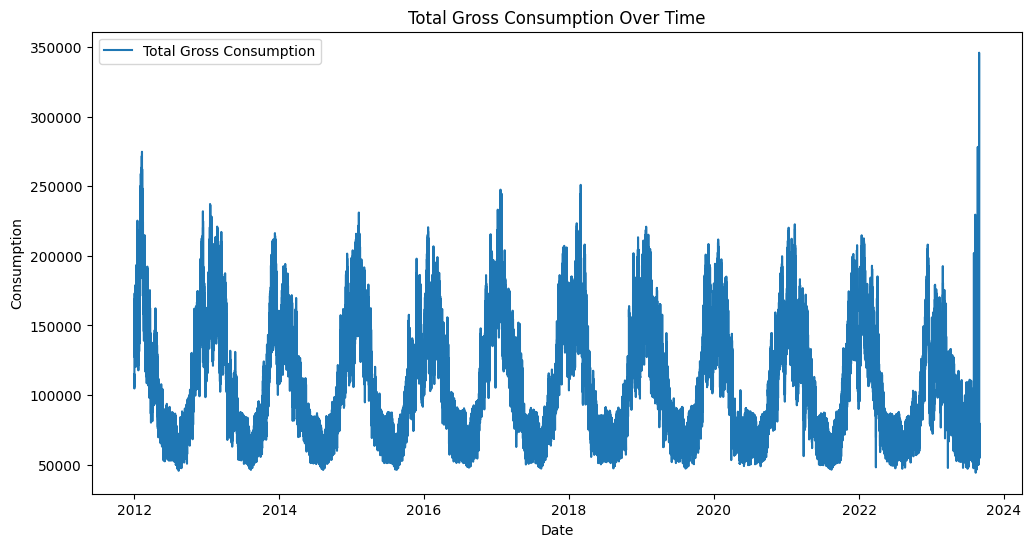

In [9]:
basic_plot(cleaned_data['date_heure'],
           cleaned_data['consommation_brute_totale'],
            title='Total Gross Consumption Over Time',
              labels={'label':'Total Gross Consumption', 'xlabel':'Date', 'ylabel':'Consumption'})

In [10]:
cleaned_data['mois'] = cleaned_data['date_heure'].dt.month
cleaned_data['jour'] = cleaned_data['date_heure'].dt.day
cleaned_data['heure'] = cleaned_data['date_heure'].dt.hour

/var/folders/9y/nmh0_sr95hl2dtlk_17wzx6h0000gn/T/ipykernel_7694/2794706359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['mois'] = cleaned_data['date_heure'].dt.month
/var/folders/9y/nmh0_sr95hl2dtlk_17wzx6h0000gn/T/ipykernel_7694/2794706359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['jour'] = cleaned_data['date_heure'].dt.day
/var/folders/9y/nmh0_sr95hl2dtlk_17wzx6h0000gn/T/ipykernel_7694/2794706359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [11]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102212 entries, 1 to 204527
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype              
---  ------                              --------------   -----              
 0   date_heure                          102212 non-null  datetime64[ns, UTC]
 1   date                                102212 non-null  object             
 2   heure                               102212 non-null  int32              
 3   consommation_brute_gaz_grtgaz       102212 non-null  float64            
 4   statut_grtgaz                       102212 non-null  object             
 5   consommation_brute_gaz_terega       102212 non-null  float64            
 6   statut_terega                       102212 non-null  object             
 7   consommation_brute_gaz_totale       102212 non-null  float64            
 8   consommation_brute_electricite_rte  102212 non-null  int64              
 9   statut_rte                     

In [13]:
X, y = create_dataset_numpy_array(cleaned_data, ts_lenght=24)

In [14]:
print(X[0][23])
print("\n")
print(y[0])

[ 1.          1.         22.          0.          0.          1.
  0.0236664   0.09785669  0.02919754  0.25712043  0.0991751 ]


[ 1.          1.         23.          0.          0.          1.
  0.0630933   0.07287752  0.06397872  0.13929081  0.08878082]


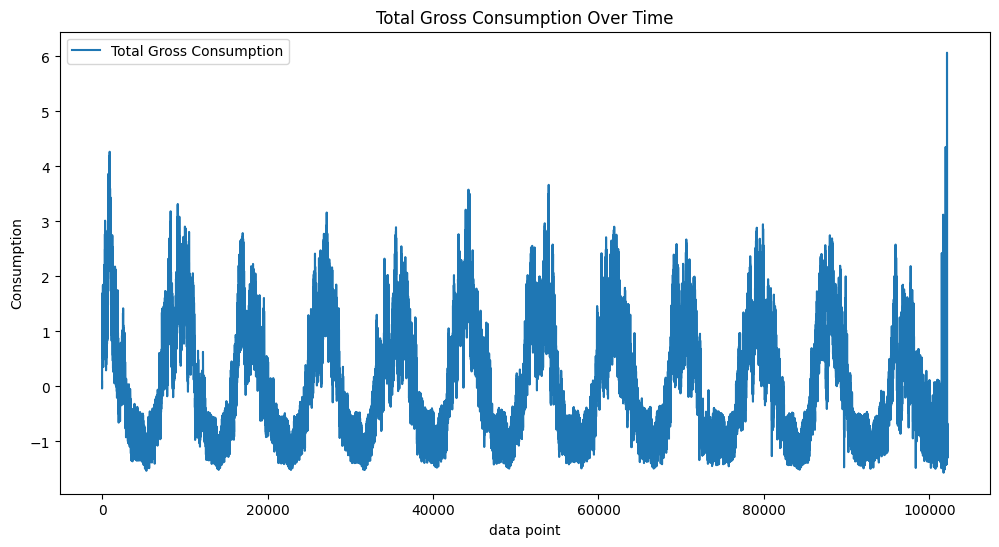

In [18]:
basic_plot(range(y.shape[0]),
           y[:, -1],
            title='Total Gross Consumption Over Time',
              labels={'label':'Total Gross Consumption', 'xlabel':'data point', 'ylabel':'Consumption'})

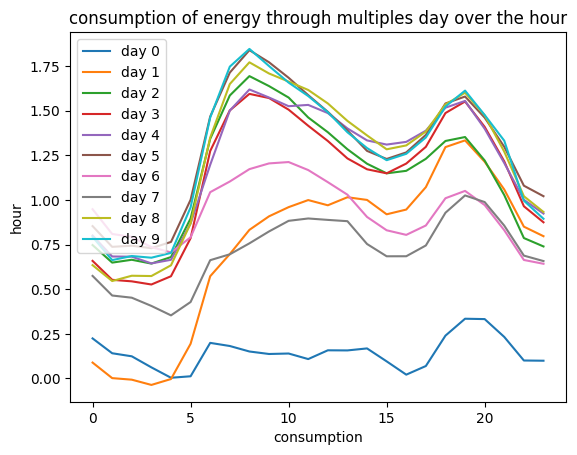

In [27]:
for i in range(10):
    x = X[i*24, : , -1]
    plt.plot(range(24), x, label=f'day {i}')
    plt.xlabel('consumption')
    plt.ylabel('hour')
plt.title('consumption of energy through multiples day over the hour')
plt.legend()
plt.show()